In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
import osmnx as ox
import networkx as nx

# Load INRIX speed data and conversion data
inrix_df = pd.read_csv('../data/Hamilton-County-INRIX.csv')
conversion_df = pd.read_csv('../data/XD_Identification.csv')

inrix_df['measurement_tstamp'] = pd.to_datetime(inrix_df['measurement_tstamp'])

In [2]:
desired_date = pd.Timestamp("2025-03-10 01:00:00").date()
inrix_df[inrix_df["measurement_tstamp"].dt.date == desired_date]

,xd_id,measurement_tstamp,speed,historical_average_speed,reference_speed,travel_time_minutes,confidence_score,cvalue
0,1386720380,2025-03-10 00:00:00,19.0,22.0,22.0,0.24,30.0,56.0
1,1386720380,2025-03-10 00:01:00,19.0,22.0,22.0,0.24,30.0,56.0
2,1386720380,2025-03-10 00:02:00,19.0,22.0,22.0,0.24,30.0,56.0
3,1386720380,2025-03-10 00:03:00,19.0,22.0,22.0,0.24,30.0,56.0
4,1386720380,2025-03-10 00:04:00,19.0,22.0,22.0,0.24,30.0,56.0
...,...,...,...,...,...,...,...,...
9772005,1386754692,2025-03-10 23:55:00,26.0,29.0,29.0,0.18,30.0,NaN
9772006,1386754692,2025-03-10 23:56:00,26.0,29.0,29.0,0.18,30.0,NaN
9772007,1386754692,2025-03-10 23:57:00,26.0,29.0,29.0,0.18,30.0,NaN
9772008,1386754692,2025-03-10 23:58:00,26.0,29.0,29.0,0.18,30.0,NaN


In [3]:
if not pd.api.types.is_datetime64_any_dtype(inrix_df['measurement_tstamp']):
    inrix_df['measurement_tstamp'] = pd.to_datetime(inrix_df['measurement_tstamp'])

# Group by xd_id and resample by hour to get hourly means
hourly_inrix_df = (inrix_df
    .set_index('measurement_tstamp')
    .groupby('xd_id')
    .resample('H')
    .agg({
        'speed': 'mean',
        'historical_average_speed': 'mean',
        'reference_speed': 'mean',
        'travel_time_minutes': 'mean',
        'confidence_score': 'mean',
        'cvalue': 'mean'
    })
    .reset_index()
)

# Format the result
hourly_inrix_df = hourly_inrix_df.round(2)  # Round to 2 decimal places

In [ ]:
# desired_time = pd.Timestamp("2025-03-10 01:00:00")
inrix_snapshot = hourly_inrix_df[hourly_inrix_df['measurement_tstamp'] == desired_time]

In [4]:
# Merge INRIX speed data with segment geometries
merged_df = pd.merge(inrix_snapshot, conversion_df, left_on='xd_id', right_on='xd')

# Create list of LineStrings
geometries = [
    LineString([(x1, y1), (x2, y2)]) 
    for x1, y1, x2, y2 in zip(
        merged_df['start_longitude'], 
        merged_df['start_latitude'], 
        merged_df['end_longitude'], 
        merged_df['end_latitude']
    )
]

# Create GeoDataFrame with geometries
inrix_gdf = gpd.GeoDataFrame(
    merged_df.drop(['geometry'], axis=1, errors='ignore'), 
    geometry=geometries, 
    crs='EPSG:4326'
)

NameError: name 'inrix_snapshot' is not defined

In [35]:
# Determine bounding box from inrix_gdf
minx, miny, maxx, maxy = inrix_gdf.total_bounds

# Fetch OSM road network for driving within bounding box
G = ox.graph_from_bbox(north=maxy, south=miny, east=maxx, west=minx, network_type='drive')
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

In [36]:
# Project to metric CRS for spatial computations
inrix_proj = inrix_gdf.to_crs(epsg=3857)
edges_proj = edges.to_crs(epsg=3857)

# Spatial join to find nearest edge to each INRIX segment
joined = gpd.sjoin_nearest(inrix_proj, edges_proj, how='left', distance_col='dist')

In [37]:
# Extract u, v, key from joined DataFrame
joined['u'] = joined['index_right0']
joined['v'] = joined['index_right1']
joined['key'] = joined['index_right2']

# Now you can locate OSM edge in the graph G
edge = G.get_edge_data(joined.loc[0, 'u'], joined.loc[0, 'v'], joined.loc[0, 'key'])

joined[['index_right0', 'index_right1', 'index_right2', 'osmid', 'speed', 'length', 'dist']].head()

,index_right0,index_right1,index_right2,osmid,speed,length,dist
0,202625263,202684132,0,"[19503543, 19496335]",26.2,490.300,0.439654
1,202603261,1529880196,0,765609354,21.2,105.932,0.000000
1,1529880196,202603261,0,765609354,21.2,105.932,0.000000
1,1447138679,1529880196,0,53386144,21.2,69.772,0.000000
1,1529880196,1447138679,0,53386144,21.2,69.772,0.000000


In [38]:
# Update edge weights in graph G for this snapshot
for idx, row in joined.iterrows():
    u, v, key = row['index_right0'], row['index_right1'], row['index_right2']
    speed = row['speed']
    length = row['length']
    
    if pd.notnull(speed) and speed > 0:
        travel_time = (3.6 * length) / speed  # in seconds
        G[u][v][key]['travel_time'] = travel_time
        G[u][v][key]['weight'] = travel_time  # for routing


In [ ]:
zero_weight_edges = []

for u, v, k, data in G.edges(keys=True, data=True):
    weight = data.get('weight', None)
    if (weight == 0) or (weight == None):
        zero_weight_edges.append((u, v, k, data))

In [ ]:
zero_weight_count = 0
valid_weight_count = 0

for u, v, k, data in G.edges(keys=True, data=True):
    weight = data.get('weight', None)
    if weight == 0:
        zero_weight_count += 1
    elif pd.notnull(weight) and weight > 0:
        valid_weight_count += 1

# Total edges with weights considered
total_weighted_edges = zero_weight_count + valid_weight_count

# Compute ratio
if total_weighted_edges > 0:
    zero_weight_ratio = zero_weight_count / total_weighted_edges
    valid_weight_ratio = valid_weight_count / total_weighted_edges
else:
    zero_weight_ratio = valid_weight_ratio = 0.0

# Print results
print(f"Zero-weight edges: {zero_weight_count}")
print(f"Valid-weight edges: {valid_weight_count}")
print(f"Ratio of zero-weight edges: {zero_weight_ratio:.4f}")
print(f"Ratio of valid-weight edges: {valid_weight_ratio:.4f}")

In [80]:
default_speed_kmh = 66  # km/h, or 40 mi/h

for u, v, k, data in zero_weight_edges:
    length = data.get('length', None)
    if length:
        travel_time = (3.6 * length) / default_speed_kmh  # seconds
        data['weight'] = travel_time

## test

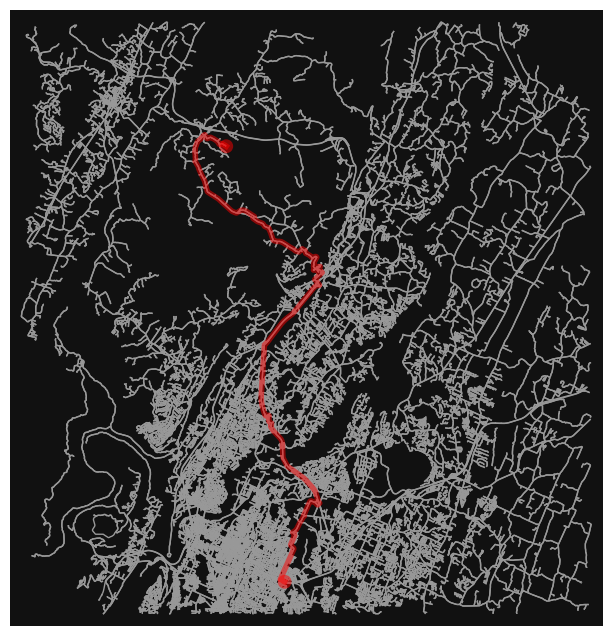

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [81]:
orig_lat, orig_lon = 35.0050, -85.2270
dest_lat, dest_lon = 35.3380, -85.2750

orig_node = ox.distance.nearest_nodes(G, X=orig_lon, Y=orig_lat)
dest_node = ox.distance.nearest_nodes(G, X=dest_lon, Y=dest_lat)

# Compute shortest path using real-time weights
route = nx.shortest_path(G, source=orig_node, target=dest_node, weight='weight')

# Visualize
ox.plot_graph_route(G, route, route_linewidth=4, node_size=0)

In [82]:
route_edges_info = []

for u, v in zip(route[:-1], route[1:]):
    data = G[u][v][0]  # Assuming key=0; use correct key if multi-graph
    length = data.get('length', None)
    weight = data.get('weight', None)
    
    route_edges_info.append({
        'from': u,
        'to': v,
        'length_m': length,
        'weight_sec': weight
    })

# Optional: Convert to DataFrame
import pandas as pd
route_edges_df = pd.DataFrame(route_edges_info)

# Display summary
print("\nTotal edges in route:", len(route_edges_df))
print("Total travel time (min):", route_edges_df['weight_sec'].sum() / 60)


Total edges in route: 147
Total travel time (min): 65.51705019508226


In [85]:
route_edges_info

[{'from': 445902173,
  'to': 202569787,
  'length_m': 274.74699999999996,
  'weight_sec': 20.910976744186044},
 {'from': 202569787,
  'to': 202627859,
  'length_m': 154.511,
  'weight_sec': 17.93164410058027},
 {'from': 202627859,
  'to': 202619735,
  'length_m': 180.209,
  'weight_sec': 19.00827424553179},
 {'from': 202619735,
  'to': 202627855,
  'length_m': 377.462,
  'weight_sec': 20.588836363636364},
 {'from': 202627855,
  'to': 3774424684,
  'length_m': 2.963,
  'weight_sec': 0.16161818181818183},
 {'from': 3774424684,
  'to': 202627852,
  'length_m': 140.46699999999998,
  'weight_sec': 17.009122098890007},
 {'from': 202627852,
  'to': 202695460,
  'length_m': 202.125,
  'weight_sec': 22.170932358318097},
 {'from': 202695460,
  'to': 202695462,
  'length_m': 251.305,
  'weight_sec': 13.707545454545455},
 {'from': 202695462,
  'to': 202695465,
  'length_m': 126.323,
  'weight_sec': 6.890345454545454},
 {'from': 202695465,
  'to': 202612882,
  'length_m': 117.178,
  'weight_sec': 6